# LOAD Modules

In [13]:
import numpy as np
from visualisations import eeg_sample_plot, events_distribution_plot
from sklearn.model_selection import train_test_split
from torchvision.transforms import Compose, ToTensor
from torch.utils.data import DataLoader
from datasets import ChannelsVoltageDataset
from neural_nets.nn_models_getter import get_nn_model
from optimizers import get_optimizer
from utils_train import fit, test, plot_all_metrics, plot_val_metrics
from configs import configs_ozhan, configs_tim, configs_joaquin
from mne_data_loader import get_epoched_data
from classification_results import results_storer


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select the configuration

In [14]:
""" USER: SELECT THE CONFIGURATION YOU NEED """
#myList = configs_tim.list_of_configs
#myList = configs_joaquin.list_of_configs
myList = configs_ozhan.list_of_configs

# Train

Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
3723 events found
Event IDs: [1 2 3]
2310 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 2310 events and 817 original time points ...
0 bad epochs dropped
train_ds.shape (1871, 65, 817)
cuda Will be used for training of this model.
You have 2 GPUs for training!
Learning Rate:  1e-05
Epoch 1/30: train_loss: 3193909361.7857, train_accuracy: 83.3244, val_loss: 0.0000, val_accuracy: 100.0000
Epoch 2/30: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.0000, val_accuracy: 100.0000
Epoch 3/30: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.0000, val_accuracy: 100.0000
Epoch 4/30: train_loss: 0.0000, train_accuracy: 100.0000, val_loss: 0.0000, val_accuracy: 100.0000
Epoch 5/30: train_loss: 0.0000, train_accuracy: 100.0000, val_loss

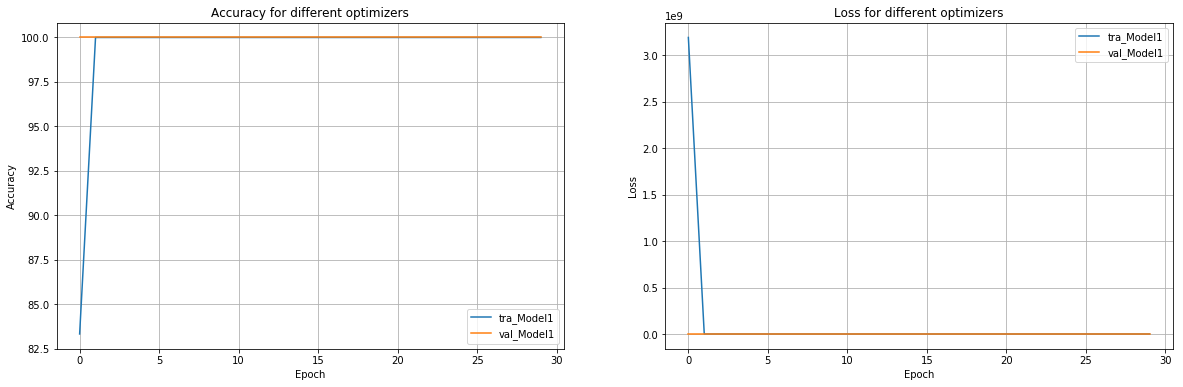

In [15]:
for my_cfg in myList:
    """LOAD RAW DATA"""
    epoched, edf_list = get_epoched_data(my_cfg)

    """SHOW DATA"""
    # Show some sample EEG data if desired
    if my_cfg.show_eeg_sample_plot:
        eeg_sample_plot(my_cfg.subjectIdx_to_plot, my_cfg.seconds_to_plot, my_cfg.channels_to_plot, edf_list)
    if my_cfg.show_events_distribution:
        events_distribution_plot(epoched.events)

    """DATA PREPARATION"""
    # Convert data from volt to millivolt
    # Pytorch expects float32 for input and int64 for labels.
    # TODO: Make this all in a data module
    event_current_class_column = 2 #event_previous_class_column = 1   event_start_sample_column = 0
    data = (epoched.get_data() * 1e6).astype(np.float32)  # Get all epochs as a 3D array.
    labels = (epoched.events[:, event_current_class_column] - 2).astype(np.int64)  # -2 -> Classes must be 0 indexed
    assert len(data) == len(labels)  # Check format

    # Split data in train test and validation set
    train_data_temp, test_data, train_labels_temp, test_labels = train_test_split(data, labels, test_size=my_cfg.test_split,
                                                                                  shuffle=True)
    train_data, val_data, train_labels, val_labels = train_test_split(train_data_temp, train_labels_temp,
                                                                      test_size=my_cfg.validation_split, shuffle=True)
    myTransforms = Compose([ToTensor()])  # TODO: This has to be more sophisticated. Should also be list selectable like the optimizers

    # Define datasets
    train_ds = ChannelsVoltageDataset(train_data, train_labels, myTransforms) # TODO: Should also be list selectable like the optimizers
    val_ds = ChannelsVoltageDataset(val_data, val_labels, myTransforms)
    test_ds = ChannelsVoltageDataset(test_data, test_labels, myTransforms)
    print("train_ds.shape", train_ds.data.shape)

    # Define data loader
    train_dl = DataLoader(train_ds, my_cfg.batch_size, shuffle=True)
    val_dl = DataLoader(val_ds, my_cfg.batch_size, shuffle=False)
    test_dl = DataLoader(test_ds, my_cfg.batch_size, shuffle=False)
    input_dimension_ = train_ds.data.shape[1] * train_ds.data.shape[2]

    """CLASSIFICATION"""
    
    training_curves = {}
    
    # Get the model
    model_untrained = get_nn_model(my_cfg.nn_list[my_cfg.nn_selection_idx], input_dimension=input_dimension_,
                                   output_dimension=len(my_cfg.selected_classes))

    # Get the optimizer
    optimizer = get_optimizer(my_cfg.optimizer_list[my_cfg.optimizer_selection_idx], my_cfg.learning_rate,
                              model_untrained.parameters(), my_cfg.momentum, my_cfg.weight_decay)

    # Train and show validation loss
    train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s =\
        fit(train_dl, val_dl, model_untrained, optimizer, my_cfg.loss_fn, my_cfg.num_of_epochs)
    
    curves = train_losses, train_accuracies, val_losses, val_accuracies, model_trained, time_spent_for_training_s
    training_curves['Model1'] = curves
    plot_all_metrics(training_curves)
    
    # Test the net
    test_loss, test_accuracy = test(model_trained, test_dl, my_cfg.loss_fn, print_loss=True)

    # Store the results
    results_storer.store_results(my_cfg, model_trained, optimizer, test_loss, test_accuracy, train_losses,
                                 train_accuracies, time_spent_for_training_s, val_losses, val_accuracies)



